In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const


$$F = \frac{GMm}{r^2} \hat{r} = \frac{GMm}{r^3} \overrightarrow{r}$$

$$F_x = \frac{GMm}{r^3}x, \quad F_y = \frac{GMm}{r^3}y $$

$$ \implies \ddot{x} = \frac{GM}{r^3}x, \quad \ddot{y} = \frac{GM}{r^3}y $$

$$ \implies \ddot{x} = \frac{GM}{{\sqrt{(x^2 + y^2)}}^3}x, \quad \ddot{y} = \frac{GM}{{\sqrt{(x^2 + y^2)}}^3}y $$

$\begin{split} \text{Acceleration} \quad f(x,y)  &:=  \ddot{x}, \ddot{y}\\ &= \frac{GM}{{r_0}^3}x_0, \frac{GM}{r_0^3}y_0, \quad \end{split}$ where $r_0 = \sqrt{(x_0^2 + y_0^2)}$



#### Steps in **Leapfrog** method:
1. INPUT: $ \quad r_0$  
2. $\phi_0 = - \bigg(\frac{p/r_0 - 1}{e} \bigg)$, where $e$ is eccentricity.  
3.$x_0 = r cos(\phi_0), \quad y_0 = r sin(\phi_0)$
4. INPUT:  
$ \quad v(t): \quad v_{x_0}, v_{y_0}$  
5. Get $v_{x_{mid}}, v_{y_{mid}}\quad $  using  
$\quad v_{mid} = v\bigg(t+ \frac{h}{2}\bigg)= v_0 + \frac{h}{2}f(x_0, y_0),$      
where $\quad f(x_0, y_0) = \frac{GM}{{r_0}^3}x_0, \frac{GM}{r_0^3}y_0, \quad $ $r_0 = \sqrt{(x_0^2 + y_0^2)}$

6. $x(t) = x_0, \quad y(t) = y_0$
7. UPDATE steps: 

**for $k^{th}$ iteration** -->       
$\quad x(t+kh) = x_{k-1} + hv\bigg(x_{k-1}, t+ \bigg(k-\frac{1}{2}\bigg)h\bigg), \\ \quad y(t+kh) = y_{k-1} + hv\bigg(y_{k-1}, t+ \bigg(k-\frac{1}{2}\bigg)h\bigg)$

$\quad v_x\bigg(t+ \bigg(k+\frac{1}{2}\bigg)h\bigg) = v_x\bigg(t+ \bigg(k-\frac{1}{2}\bigg)h\bigg) + hf\bigg(x (t+kh), y(t+kh)\bigg), \\ v_y\bigg(t+ \bigg(k+\frac{1}{2}\bigg)h\bigg) = v_y\bigg(t+ \bigg(k-\frac{1}{2}\bigg)h\bigg) + hf\bigg(x (t+kh), y(t+kh)\bigg)$




In [2]:
## Two-body dynamics: setting up Leapfrog method

In [3]:
# def v(rs, **kwargs):
#     """
#     Evaluate first time derivative of r, phi.
    
#     Inputs: r -- 2D vector w/ elems r (separation) 
#                  and phi (angle)
#     Returns: 2D array of functions v(theta) and v(omega) 
#              evaluated at these points
#     """
        
#     r, phi = rs[0], rs[1]    
    
#     vphi = np.sqrt(G*M*p)/r**2      # phi'
#     vr = (ecc/p)*r**2*np.sin(phi)*vphi
    
#     return np.array([vr, vphi], float)

In [4]:
def f(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
        
    x, y = rs[0], rs[1]  
    r = np.sqrt(x**2 + y**2)
    
    # x, y components of Acceleration 'a'
    ax = G*m_rest*x/r**3    # m_rest: mass of the body at rest
    ay = G*m_rest*y/r**3    
    
    return np.array([ax, ay], float)
    

In [12]:
def leapfrog(t0, tmax, r0, phi0, vx0, vy0, h, f, r_ref, dr_tol,  **kwargs):
    """                                                                                                                      
    Calculate a soln x(t) to a 1st-order ODE of the form x'(t)=f(x,t).                                                 
                                                                                                                             
    Uses the leapfrog method.                                                                                
    Inputs: 
    t0 & tmax (Init & final time) 
    r0 & phi0 (Init polar coordinates r & phi)
    vx0 & vy0 (Init x- & y- components of velocity)
    h (step size)
    f (function to obtain derivatives: dr, dphi)
    r_ref: expected value for r
    dr_tol: amount of allowed deviation from r_ref
    Returns: t and x (both arrays of size N=#steps)                                                                          
    """
    
    debug = False

    
    # Initialize arrays for time, position vector, & velocity vector
    t = np.array(t0)
    
    x, y = r0*math.cos(phi0), r0*math.sin(phi0)
    r = np.array([x, y], float)
    R = np.array([r])

    v0 = np.array([vx0, vy0])
    v_ = np.array([v0], float) # Initial vx, vy

    # Initialize ti, v_mid
    ti = t0
    v_mid = v0 + 0.5*h*v0  
    
    # Append initial v_mid
    v_ = np.append(v_, np.array([v_mid]), axis=0)
    
    # Initialize steps for error check
    r_check = np.sqrt(x**2 + y**2)
    err = np.array([(r_ref - r_check)/r_ref])
    
    
    # solve eqns of motion using leapfrog method
    while np.abs(r_check - r_ref) < dr_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            # calculate y(t), y'(t)
            if debug: print(ti, r, np.abs(r_check - r_ref))
            err = np.append(err, (r_ref - r_check)/r_ref) # relative error
            
            # update t, r, v_mid
            ti += h
            r += h*v_mid
            v_mid += h*f(r) 
            
            #update r_check
            r_check = np.sqrt(r[0]**2 + r[1]**2)

            # save t, r, phi_mid
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            v_ = np.append(v_, np.array([v_mid]), axis=0)
            
    # components of cartesian coords
    # R: [x, y]
    X = R[:,0]
    Y = R[:,1]
    
    return t, X, Y, v_, err


In [13]:
# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# orbit parameters
m0 = 1e12 # Msun
m1 = 1e12 # Msun
M = m0 + m1
m_rest = m1

a = 1 # (G*M*T**2/(4*np.pi**2))**(1/3)   # semi-major axis (kpc, Kepler's Law)
ecc = 1e-12 # 0.5
p = a*(1 - ecc**2)   # semi-latus rectum (kpc)

# runtime initial conditions
t0, tmax = 0, 10
h = 1e-3

# starting position of second galaxy 
r0 = p   
phi0 = -np.arccos((p - r0)/(r0*ecc))

# starting veloicity of the second galaxy
vx0 = 0
vy0 = 0

# make sure r is close to analytic value over time
dr_tol = 1e-5  # allowable error 


In [14]:
# leapfrog(t0, tmax,r0, phi0, h, f, r_ref, dr_tol,  **kwargs)
t, X, Y, v_, err =  leapfrog(t0, tmax,r0, phi0, vx0, vy0, h, f, a, dr_tol)
    

4


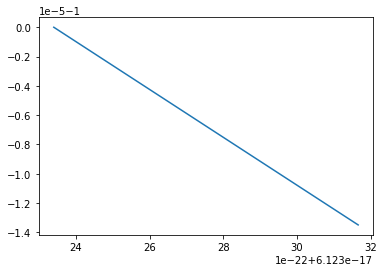

In [19]:
print(X.size)
plt.plot(X,Y);

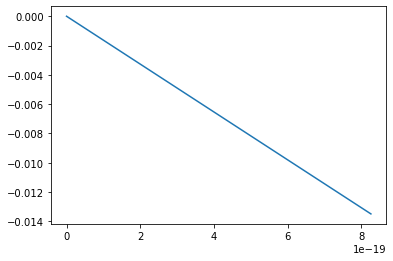

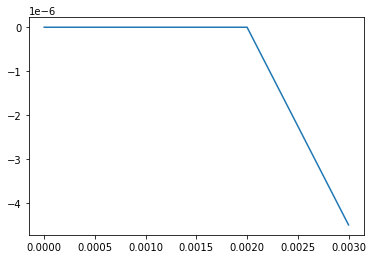

In [9]:
# plt.plot(ts, v_[:,0], label="r'(t)") # dq/dt
# plt.plot(ts, v_[:,1] - v_[0,-1], label=r"$\phi'(t)$ residual") # dq/dt
plt.plot(v_[:,0], v_[:,1])
plt.show()

plt.plot(t, err, label='error')
plt.show()
#plt.hlines(np.array([-1,1])*1e-10, 0, 10,
#           colors='grey',linestyle='--', label='tol')
#plt.legend()

NameError: name 'x' is not defined

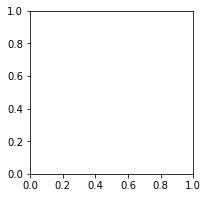

In [10]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(131, aspect='equal')
ax1.plot(x,y)
ax1.set_xlabel("x [kpc]"), ax1.set_ylabel("y [kpc]")

ax2 = fig.add_subplot(132, projection='polar')
ax2.plot(R[:,1], R[:,0])
ax2.set_xlabel("r [kpc]")

ax3 = fig.add_subplot(133,aspect='auto')
ax3.scatter(ts, err, s=1)
ax3.set_ylim(dr_tol*np.array([-1,1]))
ax3.set_xlim([0,10])
ax3.set_xlabel("time [Myr]"), ax3.set_ylabel("relative error")

In [ ]:
np.mean(R[:,0])